This notebook demonstrates how to generate a threshold for identifying noisy labels based on the methodology in Pleiss et al. (2020).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from src.data import load_dataset
from src.label_noise import (
    generate_noisy_labels, 
    create_uniform_transition_matrix,
    create_asymmetric_transition_matrix,
    validate_label_transitions,
)
from src.viz import (
    plot_roc_curve,
)
from src.scoring import compute_AUM_scores
from src.thresholding import pleiss_threshold
from src.models import get_model_default_kwargs_for_ds

DATASET_DIR = '../datasets'

In [2]:
ds_name = 'letters'

# Load the dataset
X, y = load_dataset(ds_name, save_dir=DATASET_DIR)
n_classes = len(set(y))

# Initialize the transition matrix
transition_matrix = create_uniform_transition_matrix(n_classes, 0.1)

# Generate noisy labels
y_noisy, noise_mask = generate_noisy_labels(
    y, transition_matrix, random_state=42
)

# Validate the label noise transitions
validate_label_transitions(ds_name, y, y_noisy)

# Configure model
model_config = get_model_default_kwargs_for_ds(ds_name)
model = XGBClassifier(**model_config, random_state=42)

# Compute threshold based on Pleiss et al. (2020)
label_error_threshold = pleiss_threshold(
    model, X, y_noisy
)

print(f"Label error threshold: {label_error_threshold}")

# Fit model on the noisy data
model.fit(X, y_noisy)

# Compute the AUM scores
scores = compute_AUM_scores(
    model, X, y_noisy,
)
final_scores = scores.mean(axis=1)

Label error threshold: 0.3351044741349733


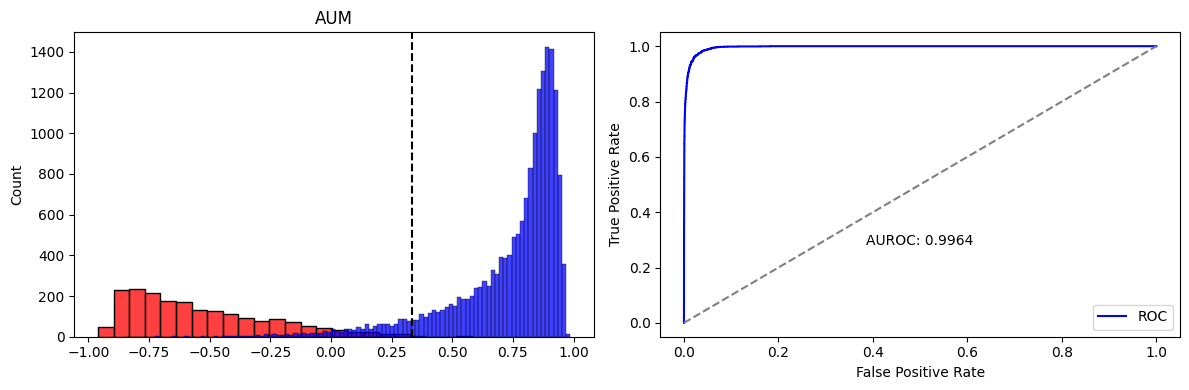

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the AUM scores
sns.histplot(data=final_scores[noise_mask], color='red', ax=ax[0])
sns.histplot(data=final_scores[~noise_mask], color='blue', ax=ax[0])

# Plot the threshold
ax[0].axvline(x=label_error_threshold, color='black', linestyle='--')

# Plot the ROC curve
plot_roc_curve(ax[1], final_scores, noise_mask)

ax[0].set_title('AUM')

plt.tight_layout()
plt.show()